In [1]:
import string
import collections

import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import FreqDist

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics
from pprint import pprint

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
wine_data = pd.read_csv('winemag-data-130k-v2.csv/winemag-data-130k-v2.csv')

In [ ]:
#nltk.download('stopwords')
nltk.download('punkt')

In [3]:
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
Unnamed: 0               129971 non-null int64
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null int64
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 13.9+ MB


In [4]:
wine_data.describe()

,Unnamed: 0,points,price
count,129971.000000,129971.000000,120975.000000
mean,64985.000000,88.447138,35.363389
std,37519.540256,3.039730,41.022218
min,0.000000,80.000000,4.000000
25%,32492.500000,86.000000,17.000000
50%,64985.000000,88.000000,25.000000
75%,97477.500000,91.000000,42.000000
max,129970.000000,100.000000,3300.000000


In [5]:

wine_data.head()


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


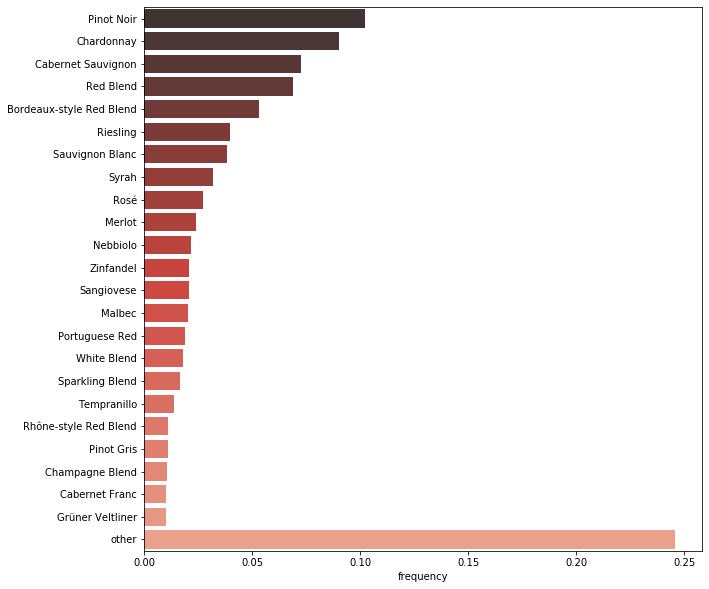

In [6]:
s2=wine_data['variety']
prob = s2.value_counts(normalize=True)
threshold = 0.01
mask = prob > threshold
tail_prob = prob.loc[~mask].sum()
prob = prob.loc[mask]
prob['other'] = tail_prob
prob = prob.to_frame()
prob = prob.rename(columns={"variety": "frequency"}) 

plt.figure(figsize=(10, 10))
sns.barplot(y=prob.index, x='frequency', data = prob, palette="Reds_d");

#prob

In [7]:
wine_data["parsed_descr"] = ""

In [29]:
def parse_decription(descr_text):
    # split into words
    tokens = word_tokenize(descr_text)

    # convert to lower case
    tokens = [w.lower() for w in tokens]

    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]

    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]

    # filter out stop words
    stop_words = set(stopwords.words('english'))
    stop_words.add('wine')
    stop_words.add('fruit')
    stop_words.add('flavor')
    words = [w for w in words if not w in stop_words]

    #print(words[:100])

    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in words]

    #print(stemmed[:100])
    
    return stemmed

In [30]:
#wine_data_p = wine_data.apply(np.sqrt)
wine_data['parsed_descr'] = wine_data['description'].apply(parse_decription)


In [32]:
wine_data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,parsed_descr,cluster
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,"[aroma, includ, tropic, broom, brimston, dri, ...",0
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,"[ripe, fruiti, smooth, still, structur, firm, ...",3
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,"[tart, snappi, flavor, lime, flesh, rind, domi...",0
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,"[pineappl, rind, lemon, pith, orang, blossom, ...",0
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,"[much, like, regular, bottl, come, across, rat...",2


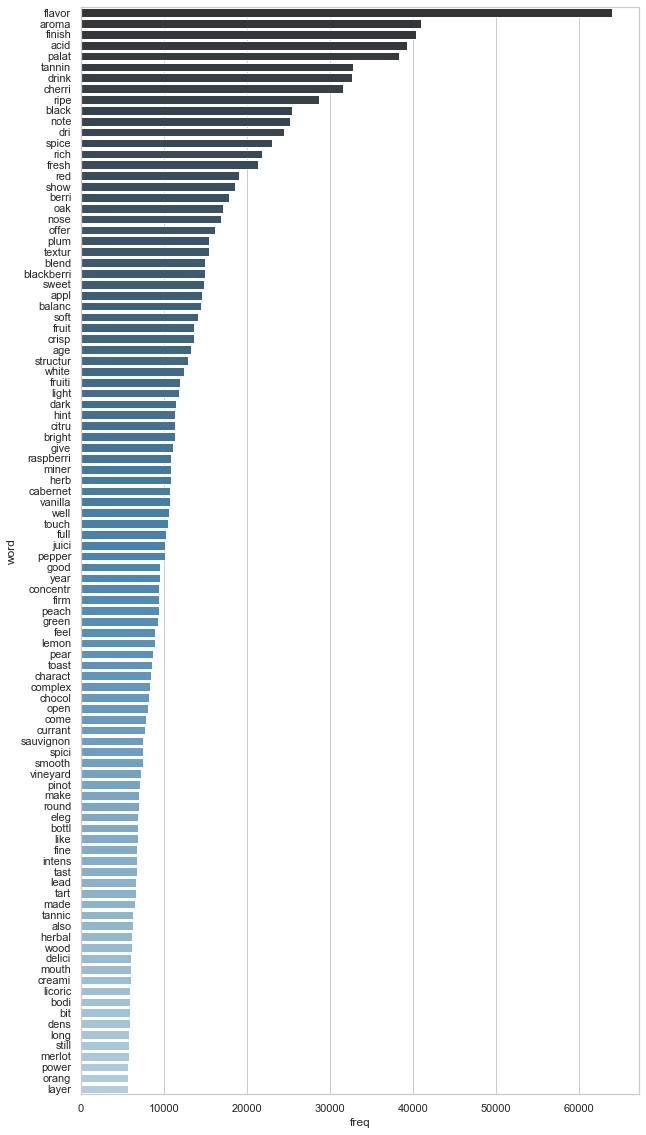

In [33]:
l = list(wine_data['parsed_descr'])
flat_list = [item for sublist in l for item in sublist]
freq = FreqDist(flat_list)

most_frequent_words = pd.DataFrame(freq.most_common(100), columns =['word', 'freq'])
most_frequent_words

sns.set(style="whitegrid")
plt.figure(figsize=(10, 20))
sns.barplot(x="freq", y="word", data=most_frequent_words, palette="Blues_d");

In [ ]:
def rem_words(querywords):
    unwanted_words = ['wine']
    return [word for word in querywords if word not in unwanted_words]

#wine_data['parsed_descr']  = wine_data['parsed_descr'].apply(rem_words)

In [34]:
vectorizer = TfidfVectorizer(lowercase=True, tokenizer=parse_decription, stop_words=set(stopwords.words('english')), max_df=80000, min_df=500, max_features=None)

In [ ]:
tfidf_model = vectorizer.fit_transform(wine_data['description'])

C:\Users\annat\Anaconda3\envs\booze\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', 'need', 'nt', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
print("n_samples: %d, n_features: %d" % tfidf_model.shape)

In [ ]:
def reduce_dimentionality(X, n_components = 3):
    
    print("Performing dimensionality reduction using LSA")

    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    explained_variance = svd.explained_variance_ratio_.sum()
    print("Explained variance of the SVD step: {}%".format(
        int(explained_variance * 100)))
    
    return X

In [ ]:
tfidf = reduce_dimentionality(tfidf_model, 400)

In [ ]:
crds =  TSNE(n_components = 3).fit_transform(tfidf)

In [ ]:
tsne_df = pd.DataFrame(crds, columns=['x','y','z'])

In [ ]:
dump(tsne_df, 'tsne_400_3d.joblib') 
#clf = load('filename.joblib') 

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_df['x'], tsne_df['y'], tsne_df['z'], c='skyblue', s=60)
#ax.view_init(30, 185)
plt.show()
 

In [15]:
# Do the actual clustering

do_mini_batches = True
how_many_clusters = 4


if do_mini_batches:
    km = MiniBatchKMeans(n_clusters=how_many_clusters, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000)
else:
    km = KMeans(n_clusters=how_many_clusters, init='k-means++', max_iter=100, n_init=1)

print("Clustering data with %s" % km)
km.fit(tfidf_model)


Clustering data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=4, n_init=1, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)


MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=1000, max_iter=100, max_no_improvement=10,
                n_clusters=4, n_init=1, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [16]:
#pickle
from joblib import dump, load
dump(km, 'wine_kmeans_2.joblib') 

['wine_kmeans_2.joblib']

In [17]:
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
#print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
#print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(tfidf_model, km.labels_, sample_size=1000))

Silhouette Coefficient: 0.008


In [18]:
wine_data["cluster"] = ""

for idx, label in enumerate(km.labels_):
    #print(idx, label)
    wine_data.at[idx,"cluster"] = label

In [ ]:
wine_data.head()

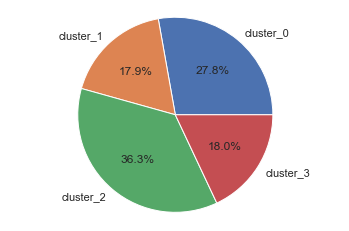

In [19]:
# let's look at the clusters

cluster_0 = wine_data.loc[wine_data['cluster'] == 0]
cluster_1 = wine_data.loc[wine_data['cluster'] == 1]
cluster_2 = wine_data.loc[wine_data['cluster'] == 2]
cluster_3 = wine_data.loc[wine_data['cluster'] == 3]

sizes = [cluster_0.shape[0],cluster_1.shape[0],cluster_2.shape[0],cluster_3.shape[0]]
labels = ['cluster_0', 'cluster_1', 'cluster_2','cluster_3']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False)
ax1.axis('equal')
plt.show()

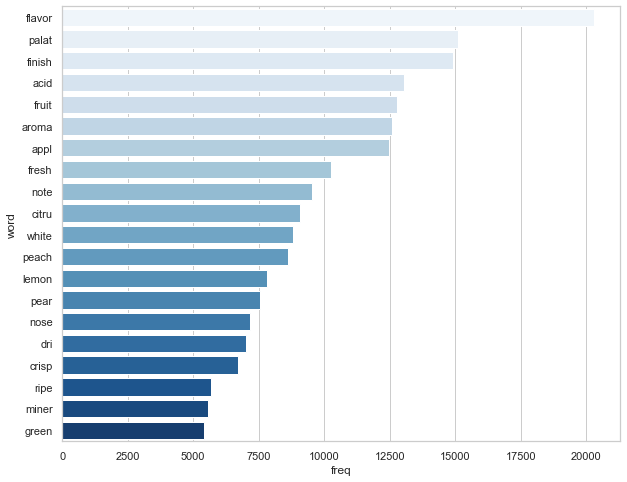

In [23]:
# for each cluster, which words are the most frequent? 
most_frequent_words = list()

l = list(cluster_0['parsed_descr'])
flat_list = [item for sublist in l for item in sublist]
freq = FreqDist(flat_list)

most_frequent_words.append(pd.DataFrame(freq.most_common(20), columns =['word', 'freq']))

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.barplot(x="freq", y="word", data=most_frequent_words[0], palette="Blues");

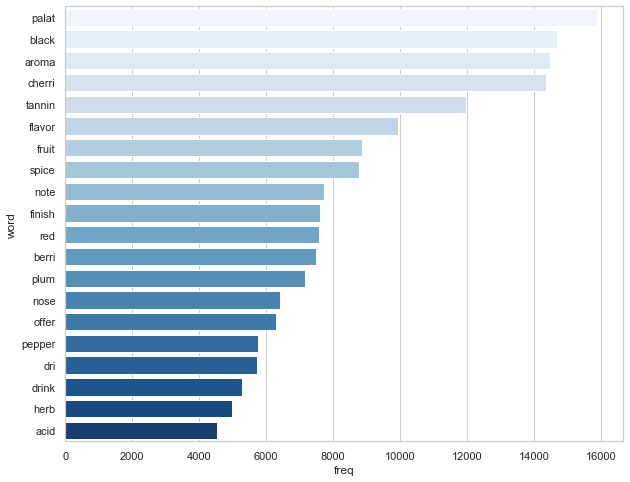

In [25]:

l = list(cluster_1['parsed_descr'])
flat_list = [item for sublist in l for item in sublist]
freq = FreqDist(flat_list)

most_frequent_words.append(pd.DataFrame(freq.most_common(20), columns =['word', 'freq']))

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.barplot(x="freq", y="word", data=most_frequent_words[1], palette="Blues");

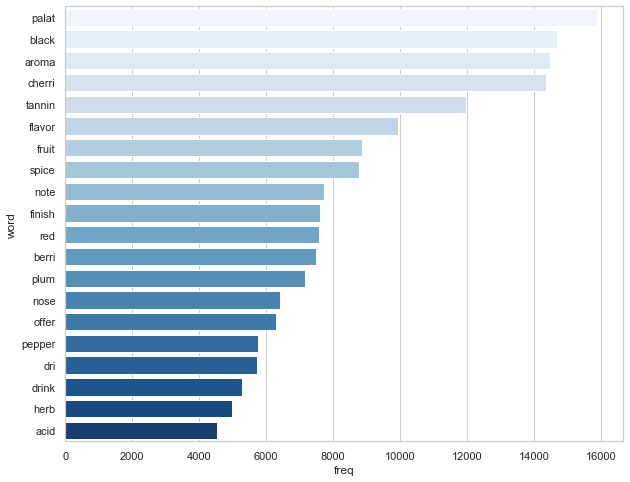

In [27]:

l = list(cluster_2['parsed_descr'])
flat_list = [item for sublist in l for item in sublist]
freq = FreqDist(flat_list)

most_frequent_words.append(pd.DataFrame(freq.most_common(20), columns =['word', 'freq']))

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.barplot(x="freq", y="word", data=most_frequent_words[2], palette="Blues");

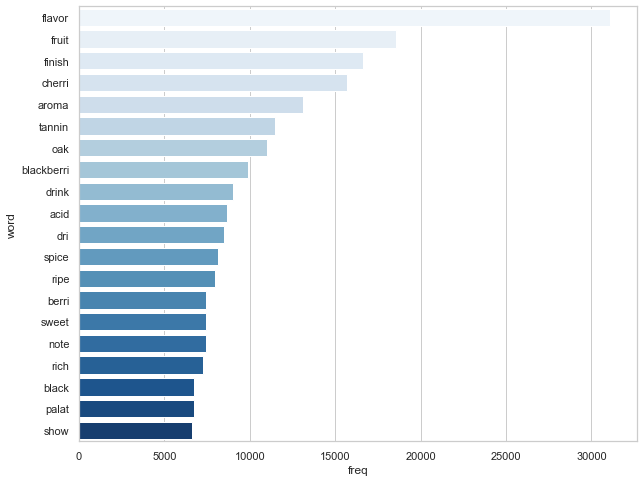

In [28]:

l = list(cluster_3['parsed_descr'])
flat_list = [item for sublist in l for item in sublist]
freq = FreqDist(flat_list)

most_frequent_words.append(pd.DataFrame(freq.most_common(20), columns =['word', 'freq']))

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
sns.barplot(x="freq", y="word", data=most_frequent_words[3], palette="Blues");

In [ ]:

l = list(cluster_4['parsed_descr'])
flat_list = [item for sublist in l for item in sublist]
freq = FreqDist(flat_list)

most_frequent_words.append(pd.DataFrame(freq.most_common(50), columns =['word', 'freq']))

sns.set(style="whitegrid")
plt.figure(figsize=(10, 10))
sns.barplot(x="freq", y="word", data=most_frequent_words[4], palette="Blues");

In [ ]:
# words that are found in both sets
print('clusters 0 and 1')
rem = (list(set(most_frequent_words[0].word) & set(most_frequent_words[1].word)))

# using list comprehension to perform task 
res = [i for i in most_frequent_words[0].word if i not in rem] 

print('clusters 0 and 2')
rem = (list(set(res) & set(most_frequent_words[2].word)))

res = [i for i in res if i not in rem] 

print('clusters 0 and 3')
rem = (list(set(res) & set(most_frequent_words[3].word)))

res = [i for i in res if i not in rem] 


print('clusters 0 and 4')
rem = (list(set(res) & set(most_frequent_words[4].word)))

res = [i for i in res if i not in rem] 
res

In [ ]:
# words that are found in both sets
print('clusters 0 and 1')
rem = (list(set(most_frequent_words[1].word) & set(most_frequent_words[0].word)))

# using list comprehension to perform task 
res = [i for i in most_frequent_words[1].word if i not in rem] 

print('clusters 0 and 2')
rem = (list(set(res) & set(most_frequent_words[2].word)))

res = [i for i in res if i not in rem] 

print('clusters 0 and 3')
rem = (list(set(res) & set(most_frequent_words[3].word)))

res = [i for i in res if i not in rem] 


print('clusters 0 and 4')
rem = (list(set(res) & set(most_frequent_words[4].word)))

res = [i for i in res if i not in rem] 
res

In [ ]:
# words that are found in both sets
print('clusters 0 and 1')
rem = (list(set(most_frequent_words[2].word) & set(most_frequent_words[0].word)))

# using list comprehension to perform task 
res = [i for i in most_frequent_words[2].word if i not in rem] 

print('clusters 0 and 2')
rem = (list(set(res) & set(most_frequent_words[1].word)))

res = [i for i in res if i not in rem] 

print('clusters 0 and 3')
rem = (list(set(res) & set(most_frequent_words[3].word)))

res = [i for i in res if i not in rem] 


print('clusters 0 and 4')
rem = (list(set(res) & set(most_frequent_words[4].word)))

res = [i for i in res if i not in rem] 
res

In [ ]:
# words that are found in both sets
print('clusters 0 and 1')
rem = (list(set(most_frequent_words[3].word) & set(most_frequent_words[0].word)))

# using list comprehension to perform task 
res = [i for i in most_frequent_words[3].word if i not in rem] 

print('clusters 0 and 2')
rem = (list(set(res) & set(most_frequent_words[1].word)))

res = [i for i in res if i not in rem] 

print('clusters 0 and 3')
rem = (list(set(res) & set(most_frequent_words[2].word)))

res = [i for i in res if i not in rem] 


print('clusters 0 and 4')
rem = (list(set(res) & set(most_frequent_words[4].word)))

res = [i for i in res if i not in rem] 
res

In [ ]:
# words that are found in both sets
print('clusters 0 and 1')
rem = (list(set(most_frequent_words[4].word) & set(most_frequent_words[0].word)))

# using list comprehension to perform task 
res = [i for i in most_frequent_words[4].word if i not in rem] 

print('clusters 0 and 2')
rem = (list(set(res) & set(most_frequent_words[1].word)))

res = [i for i in res if i not in rem] 

print('clusters 0 and 3')
rem = (list(set(res) & set(most_frequent_words[2].word)))

res = [i for i in res if i not in rem] 


print('clusters 0 and 4')
rem = (list(set(res) & set(most_frequent_words[3].word)))

res = [i for i in res if i not in rem] 
res

In [ ]:

#which variety is the most frequent? 


#Which country?